In [1]:
import sys
import os
import importlib

# Ajout du chemin une fois
sys.path.append(os.path.abspath('../../../python_files'))

# Liste des noms des modules à importer et recharger
module_names = [
    'preprocessing',
    'imports',
    'files',
    'clustering',
    'profile_prediction',
    'prediction_24h'
]

# Import et reload automatique
modules = {}
for name in module_names:
    modules[name] = importlib.import_module(name)
    importlib.reload(modules[name])

# Importer tout en global namespace (équivalent à from ... import *)
for name in module_names:
    exec(f'from {name} import *')


In [2]:
Simulation_Dataset = {
    "2018": "../../../data/simulated_data_7years/Mal_isole/2018/Simulation_Outputs",
    "2019": "../../../data/simulated_data_7years/Mal_isole/2019/Simulation_Outputs",
    "2020": "../../../data/simulated_data_7years/Mal_isole/2020/Simulation_Outputs",
    "2021": "../../../data/simulated_data_7years/Mal_isole/2021/Simulation_Outputs",
    "2022": "../../../data/simulated_data_7years/Mal_isole/2022/Simulation_Outputs",
    "2023": "../../../data/simulated_data_7years/Mal_isole/2023/Simulation_Outputs",
    "2024": "../../../data/simulated_data_7years/Mal_isole/2024/Simulation_Outputs"   
}

Weather_Dataset = {
    "2018": "../../../data/simulated_data_7years/Mal_isole/2018/Weather_Dataset.txt",
    "2019": "../../../data/simulated_data_7years/Mal_isole/2019/Weather_Dataset.txt",
    "2020": "../../../data/simulated_data_7years/Mal_isole/2020/Weather_Dataset.txt",
    "2021": "../../../data/simulated_data_7years/Mal_isole/2021/Weather_Dataset.txt",
    "2022": "../../../data/simulated_data_7years/Mal_isole/2022/Weather_Dataset.txt",
    "2023": "../../../data/simulated_data_7years/Mal_isole/2023/Weather_Dataset.txt",
    "2024": "../../../data/simulated_data_7years/Mal_isole/2024/Weather_Dataset.txt"   
}


In [28]:
consommation_chauffage = extract_and_concat_consommation(Simulation_Dataset, column_index=4, prefix="consommation_heat_")

# Exemple d'utilisation
city_groups = {
    "Weather_Dataset": Weather_Dataset
   
    
}

prefix_column_map = {
    "Text_": 1,
    "Hum_": 3,
    "Wind_": 4,
    "Solar_": 5,
    "Ground_": 10
}

combined_data = extract_and_combine_all(city_groups, prefix_column_map)
Text_combined = combined_data.get('Text_combined_Weather_Dataset')
occupation=pd.read_csv("../../../data/simulated_data_7years/Mal_isole/Occup_Schedule_Youssef.txt")
occ_df = pd.DataFrame(occupation["Occupancy"].values[:8760].reshape(-1, 24))
occupation_7years = pd.concat([occ_df] * 7, ignore_index=True)


In [29]:
clustering_heat_7years=pd.read_csv("../../../data/simulated_data_7years/result_data/clustering_heat_7years_data_from_1_novembre_to_31_avril.csv")

In [30]:
start_date = "2018-01-01"
dates = pd.date_range(start=start_date, periods=len(consommation_chauffage), freq="D") 
Text_combined.insert(0, "Date", dates)
occupation_7years.insert(0, "Date", dates)

add_heating_season(Text_combined)
add_heating_season(occupation_7years)


df_Text = Text_combined[Text_combined["heat"] == 1].drop(columns=["heat"]).copy().reset_index(drop=True)
df_occ = occupation_7years[occupation_7years["heat"] == 1].drop(columns=["heat"]).copy().reset_index(drop=True)

In [31]:
df_occ=df_occ.drop(columns=["Date"])
df_combined = pd.concat([df_Text, df_occ], axis=1)

In [34]:
df_combined['Date'] = pd.to_datetime(df_combined['Date'])
clustering_heat_7years['Date'] = pd.to_datetime(clustering_heat_7years['Date'])
df_combined = df_combined.merge(
    clustering_heat_7years[[ 'Date','heat_on', 'clusters_1']],
    on='Date',
    how='inner'  
)



Évaluation de Random Forest...


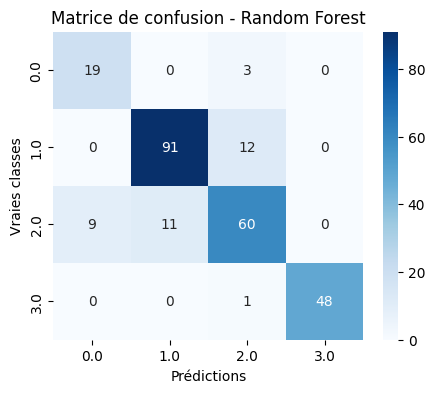

Random Forest - F1: 0.8590 - Accuracy: 0.8583 - Temps: 0.51s
###################################################################

Évaluation de Logistic Regression...


c:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


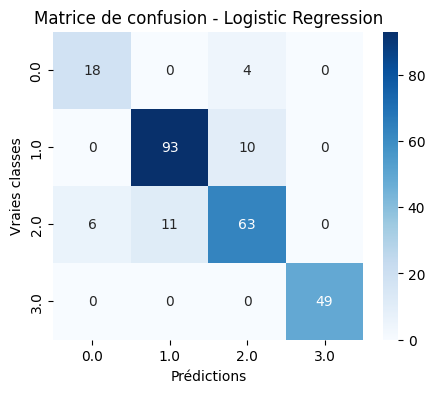

Logistic Regression - F1: 0.8778 - Accuracy: 0.8780 - Temps: 0.75s
###################################################################

Évaluation de SVC...


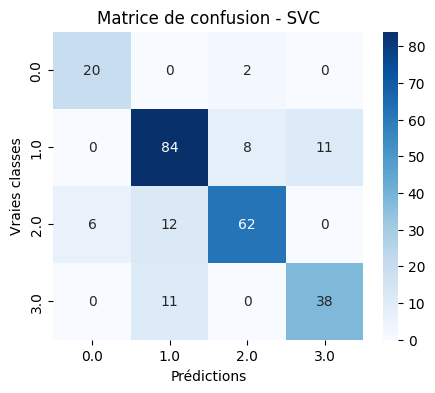

SVC - F1: 0.8031 - Accuracy: 0.8031 - Temps: 0.08s
###################################################################

Évaluation de KNN...


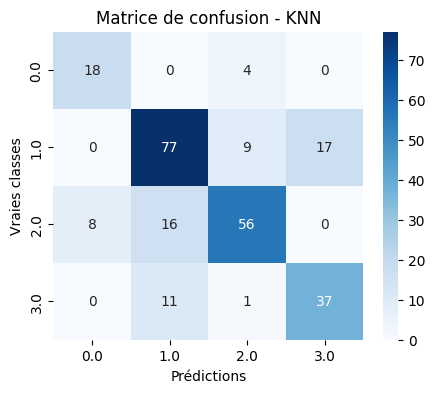

KNN - F1: 0.7404 - Accuracy: 0.7402 - Temps: 0.40s
###################################################################

Évaluation de Gradient Boosting...


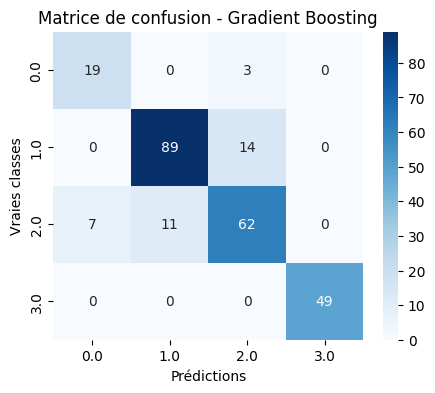

Gradient Boosting - F1: 0.8627 - Accuracy: 0.8622 - Temps: 5.12s
###################################################################


In [36]:
df_combined.columns = df_combined.columns.astype(str)

re, Test_Text_heat_toulouse = evaluate_models_split(
    df=df_combined.drop(columns=["Date"]),
    target_cols="clusters_1",
    models=models,
    split_ratio=8
)


## Remplacement des profils réels par les profils prédits

Pour la partie test (les 20% dernières données), nous remplaçons les profils de consommation réels par les profils prédits générés par le meilleur modèle de régression logistique (`y_pred_Logistic Regression_clusters_1`). 


Cela simule un scénario réaliste où seules les données historiques jusqu'à la partie test sont observées, et où les prédictions de 24 heures sont réalisées sur des profils non observés, basées sur les résultats du modèle.


In [ ]:
n = len(df_combined)
cutoff = int(n * 0.8)  # 80% des données

# Vérifier la taille
assert len(Test_Text_heat_toulouse) == n - cutoff, "Les tailles ne correspondent pas !"

new_cluster_1 = df_combined['clusters_1'].copy()

# Remplacer les 20% derniers par la colonne y_pred_... de Test_Text_heat_toulouse (qui est déjà les 20%)
new_cluster_1.iloc[cutoff:] = Test_Text_heat_toulouse['y_pred_Logistic Regression_clusters_1'].values

df_combined['clusters_1'] = new_cluster_1


In [37]:
df_combined.to_csv("../../../data/simulated_data_7years/result_data/profile_prediction_Text_Occupation_7years_data_from_1_novembre_to_31_avril.csv", index=False)
